In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from textblob import TextBlob
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm

# 1. Data Preprocessing

In [2]:
df = pd.read_csv('/Users/tabassum/Downloads/BUSS6002_Assignment_Pack/analysis/shitrentals.csv')

In [3]:
df.head()

,review_id,date,score,lessor,agency_name,property_type,weekly_price,n_bedrooms,suburb,review_text
0,1,24/11/23 4:08,5,Agency,McGrath Estate Agents,Flat/Unit,400,2,Redfern,Living in this apartment was quite the ordeal....
1,2,2/8/23 13:33,4,Agency,Ray White Group,Flat/Unit,300,2,Camperdown,Lease violations were a significant issue in t...
2,3,3/8/23 2:08,3,Agency,Harcourts,Flat/Unit,290,2,Camperdown,Communication with the landlord was a nightmar...
3,4,13/1/23 11:21,5,Agency,Harcourts,Flat/Unit,395,2,Redfern,"The property condition was disappointing, to s..."
4,5,30/12/23 11:07,5,Agency,Century 21 Australia,Flat/Unit,395,2,Redfern,Pest problems and lease violations plagued my ...


In [4]:
has_unit = (df['property_type'] == 'Unit').any()
has_unit

False

In [5]:
#check for missing values
df.isnull().sum()

review_id          0
date               0
score              0
lessor             0
agency_name      203
property_type      0
weekly_price       0
n_bedrooms         0
suburb             0
review_text        0
dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['date'],errors='coerce')
df['agency_name'].fillna('No Agency',inplace=True)
df.dtypes

/var/folders/yb/zc_tf86s03d0ft7py31xy3wr0000gn/T/ipykernel_3592/845706946.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'],errors='coerce')


review_id                 int64
date             datetime64[ns]
score                     int64
lessor                   object
agency_name              object
property_type            object
weekly_price              int64
n_bedrooms                int64
suburb                   object
review_text              object
dtype: object

In [7]:
df['weekly_price'].max()

425

# EDA 

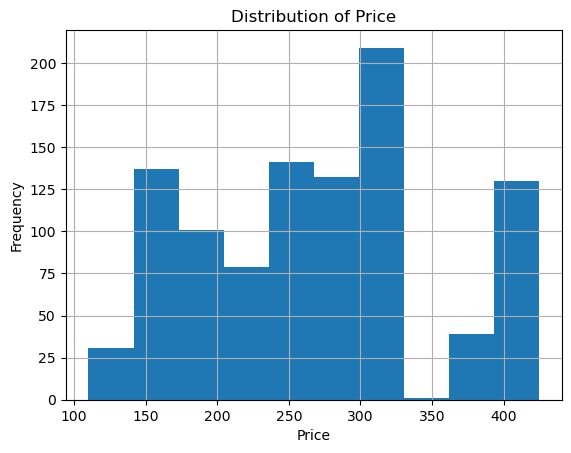

In [8]:
#understanding weekly price for all rentals 
df['weekly_price'].hist()
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

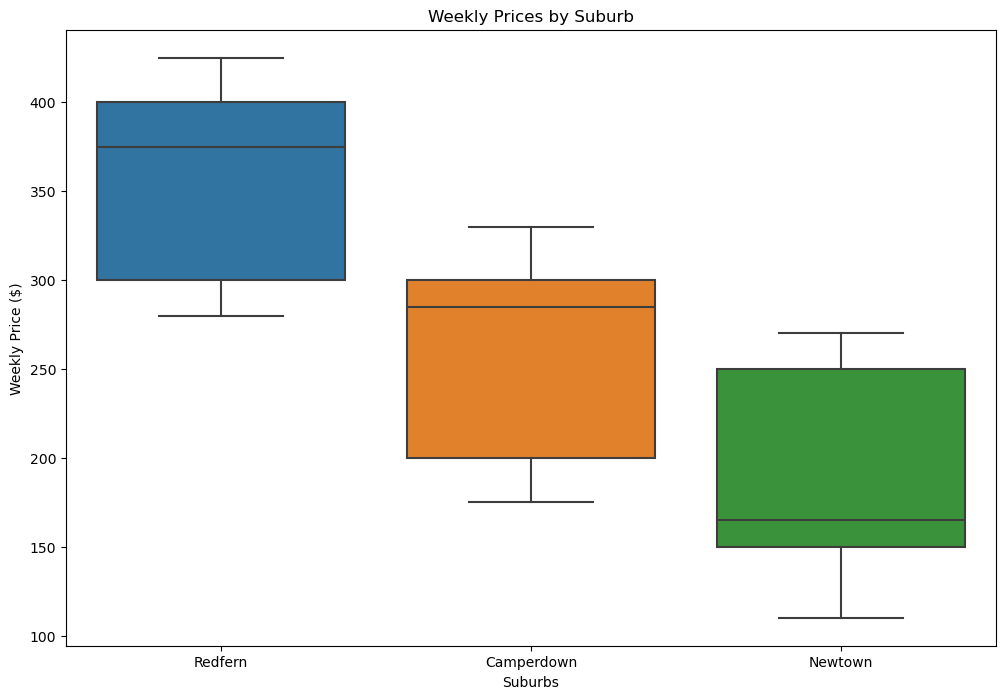

In [9]:
#how the prices diffrentiate between suburbs
plt.figure(figsize=(12, 8))
sns.boxplot(x='suburb', y='weekly_price', data=df)
plt.title('Weekly Prices by Suburb')
plt.xlabel('Suburbs')
plt.ylabel('Weekly Price ($)')
plt.xticks() 
plt.show()

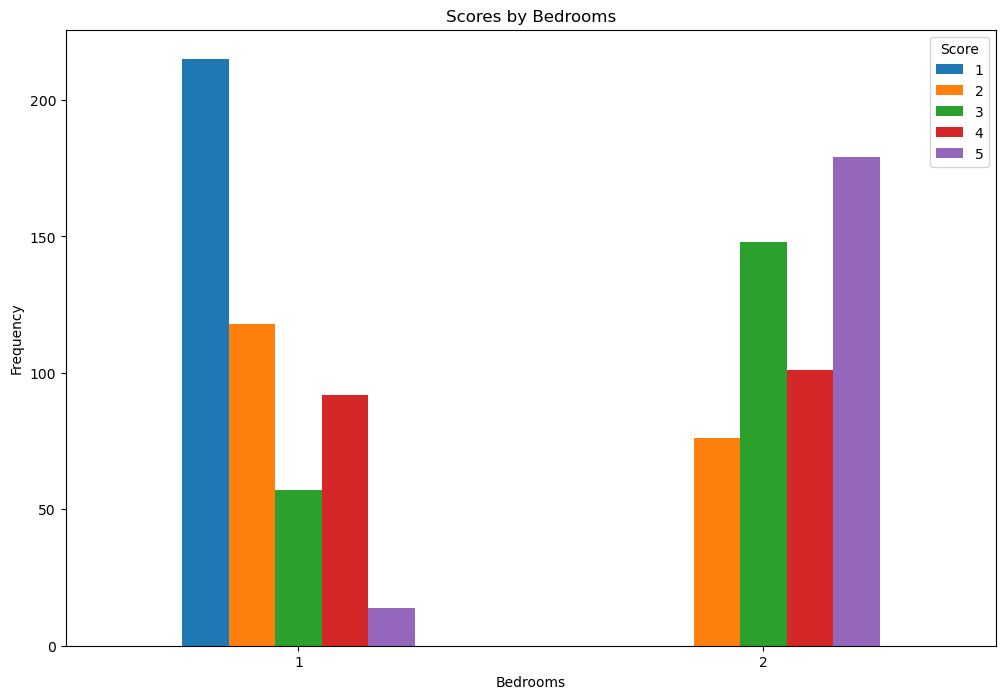

In [10]:
#are scores by bedrooms  
score_counts = pd.crosstab(df['n_bedrooms'], df['score'])

score_counts.plot(kind='bar', stacked=False, figsize=(12, 8))
plt.title('Scores by Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.legend(title='Score')
plt.show()


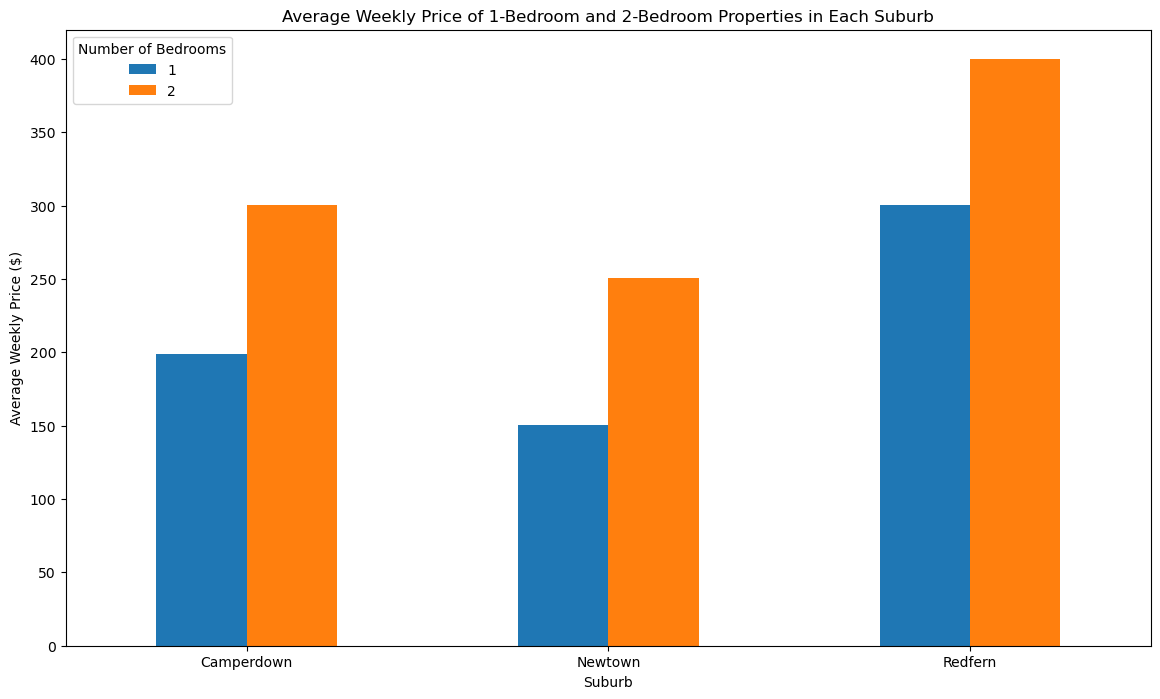

In [11]:
#number of bedrooms and suburbs + price 
df_filtered = df[df['n_bedrooms'].isin([1, 2])]
price_grouped_df = df_filtered.groupby(['suburb', 'n_bedrooms'])['weekly_price'].mean().unstack(fill_value=0)
price_grouped_df.plot(kind='bar', stacked=False, figsize=(14, 8),rot=0)
plt.title('Average Weekly Price of 1-Bedroom and 2-Bedroom Properties in Each Suburb')
plt.xlabel('Suburb')
plt.ylabel('Average Weekly Price ($)')
plt.legend(title='Number of Bedrooms')
plt.show()

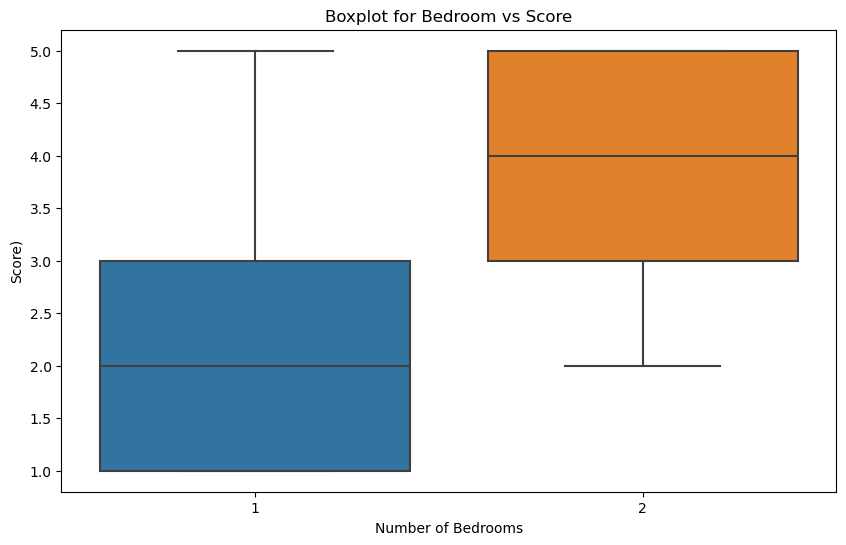

In [12]:
#score between suburbs and bedrooms
plt.figure(figsize=(10, 6))
sns.boxplot(x='n_bedrooms', y='score', data=df)
plt.title('Boxplot for Bedroom vs Score')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Score)')
plt.show()


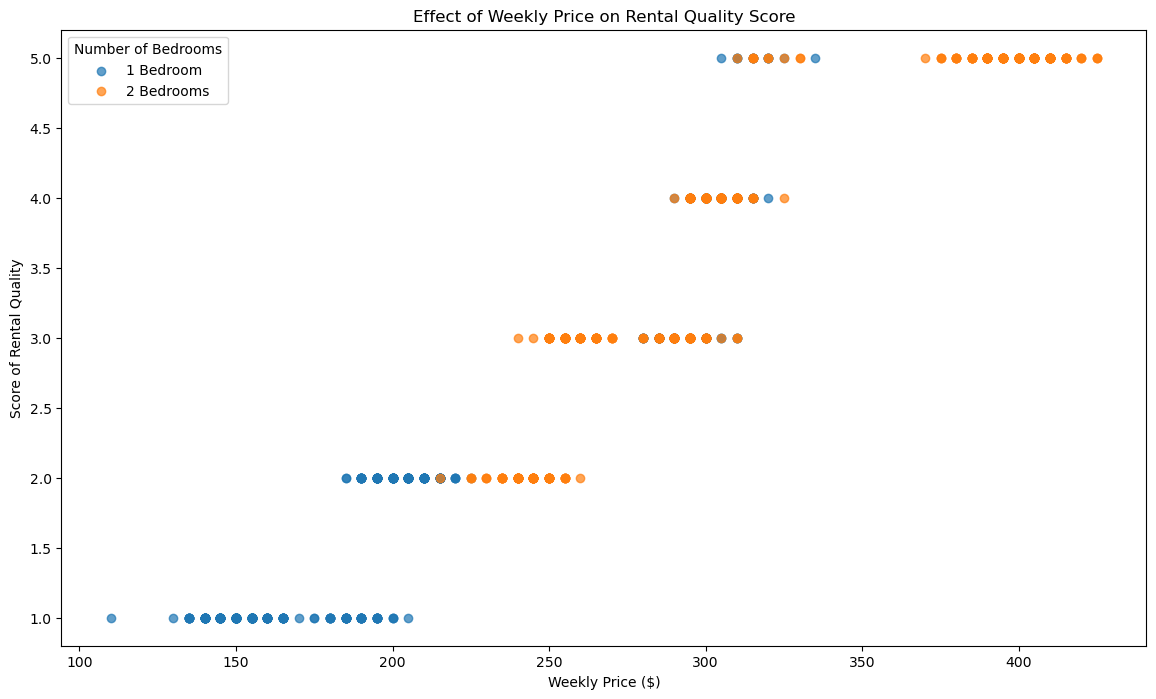

In [13]:
#socres vs bedrooms and weekly price 
plt.figure(figsize=(14, 8))
one_bedroom = df_filtered[df_filtered['n_bedrooms'] == 1]
plt.scatter(one_bedroom['weekly_price'], one_bedroom['score'], label='1 Bedroom', alpha=0.7)
two_bedroom = df_filtered[df_filtered['n_bedrooms'] == 2]
plt.scatter(two_bedroom['weekly_price'], two_bedroom['score'], label='2 Bedrooms', alpha=0.7)
plt.title('Effect of Weekly Price on Rental Quality Score')
plt.xlabel('Weekly Price ($)')
plt.ylabel('Score of Rental Quality')
plt.legend(title='Number of Bedrooms')
plt.show()

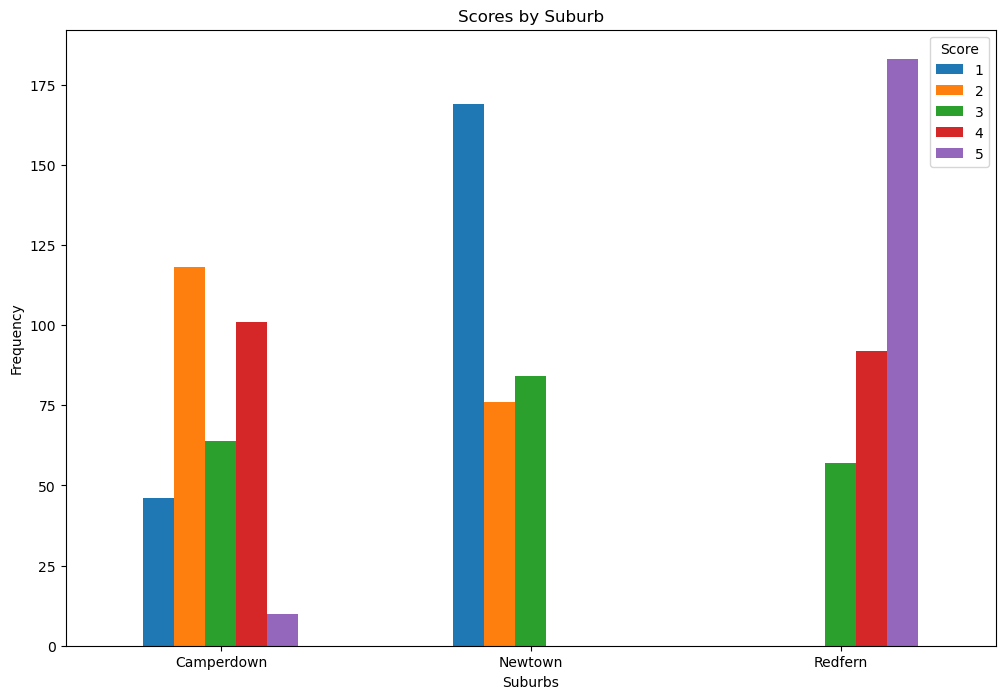

In [14]:
#scores by suburbs 
score_counts = pd.crosstab(df['suburb'], df['score'])

score_counts.plot(kind='bar', stacked=False, figsize=(12, 8))
plt.title('Scores by Suburb')
plt.xlabel('Suburbs')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.legend(title='Score')
plt.show()


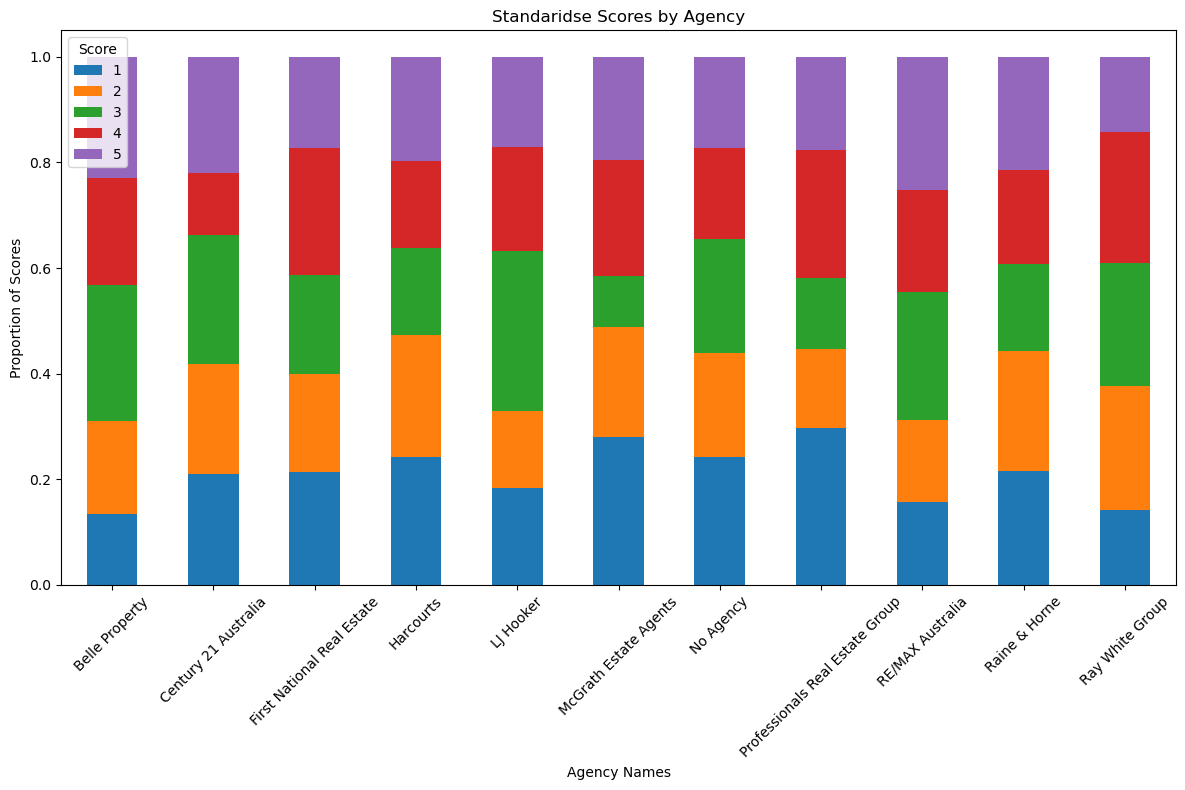

In [15]:
#scores by agency names
score_counts = pd.crosstab(df['agency_name'], df['score'])
score_counts_normalized = score_counts.div(score_counts.sum(axis=1), axis=0)
score_counts_normalized.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Standaridse Scores by Agency')
plt.xlabel('Agency Names')
plt.ylabel('Proportion of Scores')
plt.xticks(rotation=45)
plt.legend(title='Score')
plt.tight_layout()
plt.show()


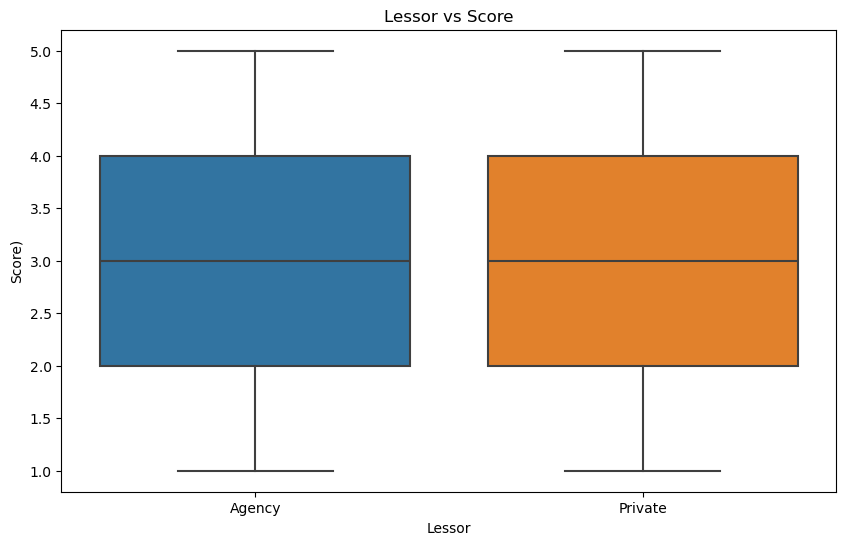

In [16]:
#lessors
plt.figure(figsize=(10, 6))
sns.boxplot(x='lessor', y='score', data=df)
plt.title('Lessor vs Score')
plt.xlabel('Lessor')
plt.ylabel('Score)')
plt.show()


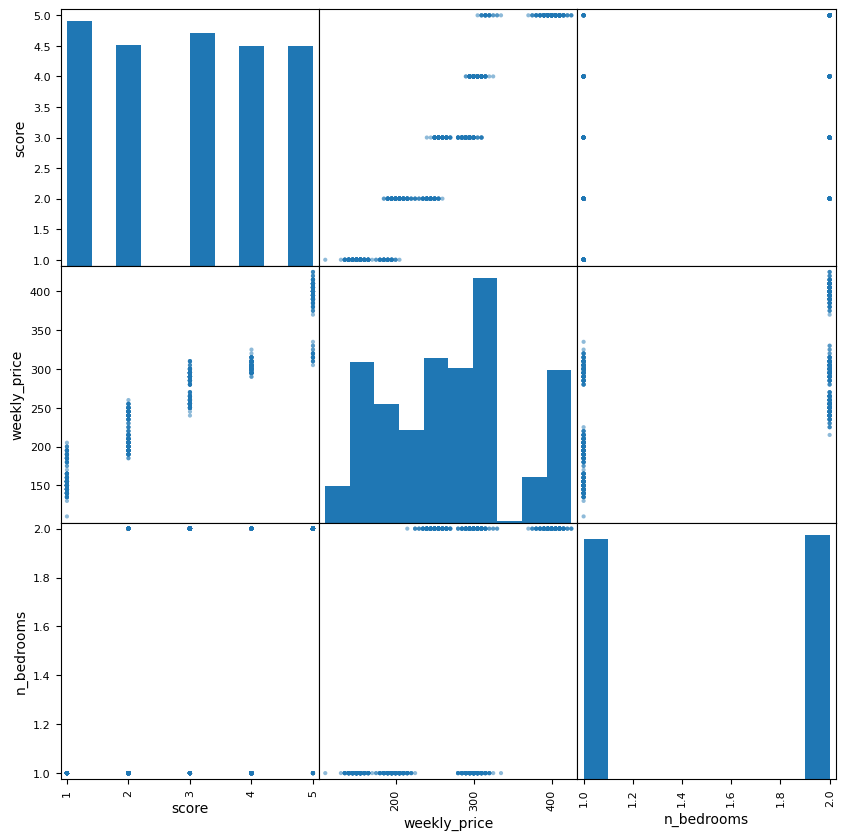

In [17]:
score_pred = df.drop(['review_id'], axis=1)  

# Drop the last 2 columns

pd.plotting.scatter_matrix(score_pred, figsize=(10, 10))  
plt.show()

In [18]:
score_pred.corr(numeric_only=True)

,score,weekly_price,n_bedrooms
score,1.000000,0.959895,0.571317
weekly_price,0.959895,1.000000,0.630756
n_bedrooms,0.571317,0.630756,1.000000


In [19]:
#understanding the review_text sentiments 
from textblob import TextBlob
for index, row in df.iterrows():
    blob = TextBlob(row['review_text'])
    if blob.sentiment.polarity > 0:
        df.at[index, 'sentiment'] = 1  # Positive sentiment
    else:
        df.at[index, 'sentiment'] = 0  # Negative sentiment
df.head()

,review_id,date,score,lessor,agency_name,property_type,weekly_price,n_bedrooms,suburb,review_text,sentiment
0,1,2023-11-24 04:08:00,5,Agency,McGrath Estate Agents,Flat/Unit,400,2,Redfern,Living in this apartment was quite the ordeal....,1.0
1,2,2023-02-08 13:33:00,4,Agency,Ray White Group,Flat/Unit,300,2,Camperdown,Lease violations were a significant issue in t...,1.0
2,3,2023-03-08 02:08:00,3,Agency,Harcourts,Flat/Unit,290,2,Camperdown,Communication with the landlord was a nightmar...,1.0
3,4,2023-01-13 11:21:00,5,Agency,Harcourts,Flat/Unit,395,2,Redfern,"The property condition was disappointing, to s...",0.0
4,5,2023-12-30 11:07:00,5,Agency,Century 21 Australia,Flat/Unit,395,2,Redfern,Pest problems and lease violations plagued my ...,0.0


<Figure size 1200x800 with 0 Axes>

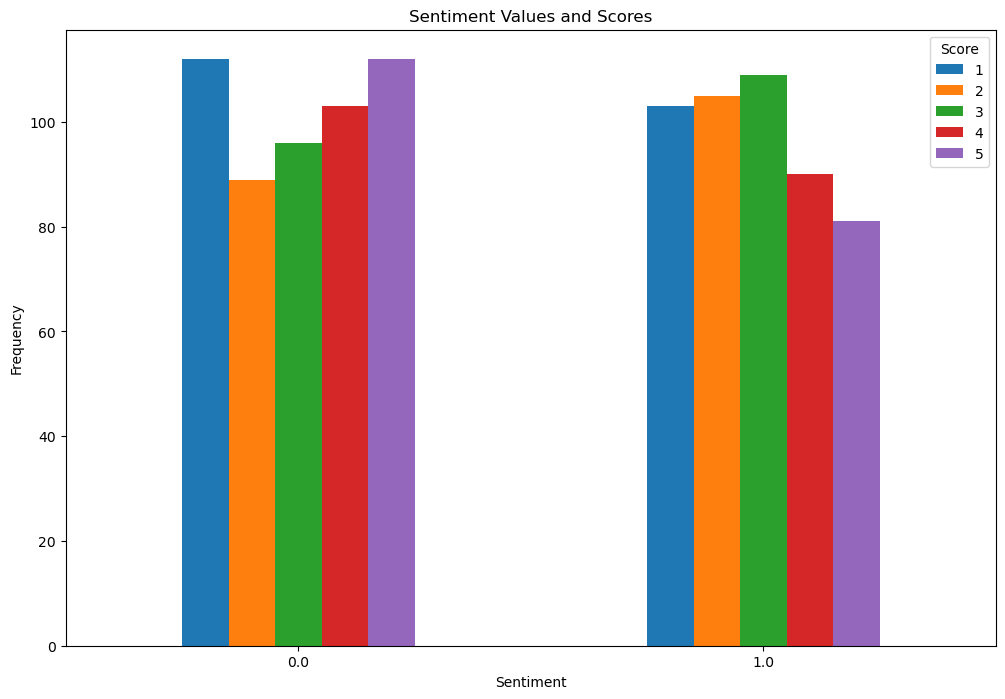

In [20]:
plt.figure(figsize=(12, 8))
sentiment_score_counts = pd.crosstab(df['sentiment'], df['score'])
sentiment_score_counts.plot(kind='bar', stacked=False, figsize=(12, 8))
plt.title('Sentiment Values and Scores')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Score')
plt.show()


# 2. Modelling (Ordinal Logisitc Regression)

### 2.1 Model Selection

In [21]:
#converting the ordinal outcome to categorical and making categorical into dummy variables 
df['score'] = df['score'].astype('category')
df['sentiment'] = df['sentiment'].astype('category')

categorical_columns = ['suburb','agency_name','sentiment']
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)

numeric_columns = ['weekly_price', 'n_bedrooms']
combined_features_df = pd.concat([df[numeric_columns], df_encoded], axis=1)
df_encoded

,suburb_Newtown,suburb_Redfern,agency_name_Century 21 Australia,agency_name_First National Real Estate,agency_name_Harcourts,agency_name_LJ Hooker,agency_name_McGrath Estate Agents,agency_name_No Agency,agency_name_Professionals Real Estate Group,agency_name_RE/MAX Australia,agency_name_Raine & Horne,agency_name_Ray White Group,sentiment_1.0
0,False,True,False,False,False,False,True,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,True,True
2,False,False,False,False,True,False,False,False,False,False,False,False,True
3,False,True,False,False,True,False,False,False,False,False,False,False,False
4,False,True,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,True,False,False,False,False,False,False,False,False,True,False,False
996,False,False,False,False,False,True,False,False,False,False,False,False,False
997,True,False,False,False,False,False,False,True,False,False,False,False,False
998,True,False,False,False,False,True,False,False,False,False,False,False,False


In [22]:
combined_features_df

,weekly_price,n_bedrooms,suburb_Newtown,suburb_Redfern,agency_name_Century 21 Australia,agency_name_First National Real Estate,agency_name_Harcourts,agency_name_LJ Hooker,agency_name_McGrath Estate Agents,agency_name_No Agency,agency_name_Professionals Real Estate Group,agency_name_RE/MAX Australia,agency_name_Raine & Horne,agency_name_Ray White Group,sentiment_1.0
0,400,2,False,True,False,False,False,False,True,False,False,False,False,False,True
1,300,2,False,False,False,False,False,False,False,False,False,False,False,True,True
2,290,2,False,False,False,False,True,False,False,False,False,False,False,False,True
3,395,2,False,True,False,False,True,False,False,False,False,False,False,False,False
4,395,2,False,True,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,415,2,False,True,False,False,False,False,False,False,False,False,True,False,False
996,310,2,False,False,False,False,False,True,False,False,False,False,False,False,False
997,230,2,True,False,False,False,False,False,False,True,False,False,False,False,False
998,240,2,True,False,False,False,False,True,False,False,False,False,False,False,False


In [23]:
X = combined_features_df.astype(int)
y = df['score']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [24]:
model = OrderedModel(y_train, X_train, distr='logit')
res_log = model.fit(method='bfgs', disp=False)

res_log.summary()

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/miscmodels/ordinal_model.py:206: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -135.61
Model:                   OrderedModel   AIC:                             309.2
Method:            Maximum Likelihood   BIC:                             392.8
Date:                Fri, 24 May 2024                                         
Time:                        07:38:31                                         
No. Observations:                 600                                         
Df Residuals:                     581                                         
Df Model:                          15                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
weekly_price                                    0.3533      0.035     10.033      0.000       0.284       0.422
n_bedrooms                                     21.9368    406.032      0.054      0.957    -773.870     817.744
suburb_Newtown                                -14.3298    324.355     -0.044      0.965    -650.054     621.395
suburb_Redfern                                 22.3061    406.033      0.055      0.956    -773.505     818.117
agency_name_Century 21 Australia               -0.8463      0.821     -1.031      0.303      -2.455       0.762
agency_name_First National Real Estate         -0.0484      0.808     -0.060      0.952      -1.632       1.535
agency_name_Harcourts                          -1.1027      0.896     -1.230      0.219      -2.859       0.654
agency_name_LJ Hooker                          -0.3495      0.796     -0.439      0.661      -1.909       1.210
agency_name_McGrath Estate Agents              -0.4708      0.764     -0.616      0.538      -1.969       1.028
agency_name_No Agency                          -0.2899      0.702     -0.413      0.680      -1.665       1.086
agency_name_Professionals Real Estate Group     0.6024      0.854      0.705      0.481      -1.072       2.276
agency_name_RE/MAX Australia                   -0.8685      0.928     -0.936      0.349      -2.688       0.950
agency_name_Raine & Horne                      -0.7878      0.806     -0.978      0.328      -2.367       0.792
agency_name_Ray White Group                     0.1140      0.815      0.140      0.889      -1.483       1.711
sentiment_1.0                                   0.1369      0.317      0.431      0.666      -0.485       0.759
1/2                                            88.8925    406.045      0.219      0.827    -706.942     884.727
2/3                                             3.3574      8.506      0.395      0.693     -13.315      20.030
3/4                                             3.4324     10.480      0.328      0.743     -17.108      23.973
4/5                                             1.8994      0.097     19.610      0.000       1.710       2.089
===============================================================================================================
"""

In [25]:
#probabilities for predictions
predicted_all_var = res_log.model.predict(res_log.params, exog=X_test)
predicted_all_var


array([[1.02977999e-26, 3.04412610e-14, 4.56727100e-01, 5.41784367e-01,
        1.48853259e-03],
       [4.13685007e-51, 1.22289163e-38, 3.37725672e-25, 2.69138244e-22,
        1.00000000e+00],
       [1.70838816e-26, 5.05015544e-14, 5.82411184e-01, 4.16691030e-01,
        8.97786571e-04],
       [8.40679693e-30, 2.48512792e-17, 6.85846439e-04, 3.53161504e-01,
        6.46152649e-01],
       [4.46943001e-02, 9.55305700e-01, 7.23066051e-12, 0.00000000e+00,
        0.00000000e+00],
       [4.56361000e-26, 1.34904586e-13, 7.88389192e-01, 2.11274533e-01,
        3.36275438e-04],
       [1.00000000e+00, 4.37427872e-14, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.36275973e-24, 4.02844540e-12, 9.91091590e-01, 8.89714536e-03,
        1.12648537e-05],
       [1.82344183e-15, 5.36136567e-03, 9.94638634e-01, 6.70907774e-12,
        8.43769499e-15],
       [1.07985633e-27, 3.19215646e-15, 8.10155583e-02, 9.04967502e-01,
        1.40169400e-02],
       [1.17775831e-54, 3.4815

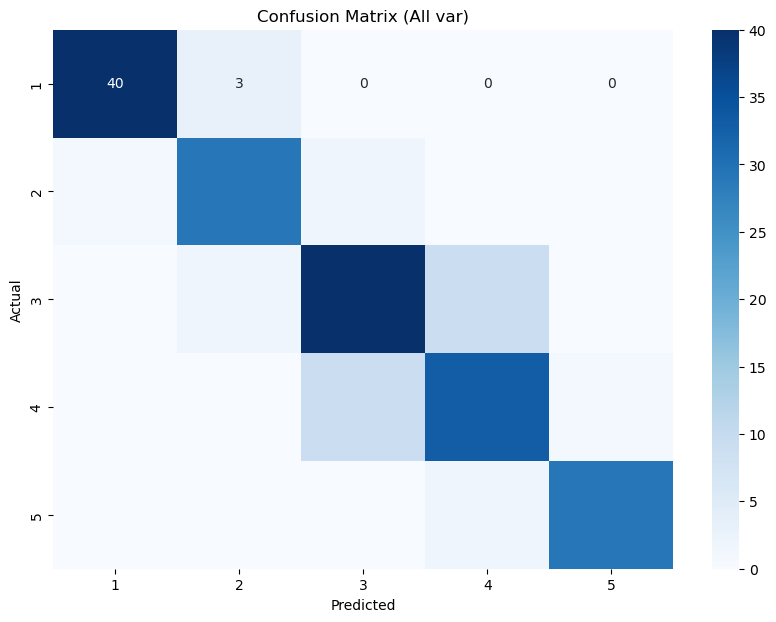

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.85      0.91      0.88        32
           2       0.78      0.78      0.78        51
           3       0.75      0.77      0.76        43
           4       0.97      0.94      0.95        31

    accuracy                           0.85       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.86      0.85      0.86       200



In [26]:
# Predict on the test set
predicted_all_var = res_log.model.predict(res_log.params, exog=X_test)
predicted_categories = np.argmax(predicted_all_var, axis=1)
y_test_numerical = y_test.cat.codes

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_numerical, predicted_categories)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['score'].cat.categories, yticklabels=df['score'].cat.categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (All var)')
plt.show()

# Classification Report
print(classification_report(y_test_numerical, predicted_categories))


In [27]:
correlation_matrix = combined_features_df.corr()
correlation_matrix

,weekly_price,n_bedrooms,suburb_Newtown,suburb_Redfern,agency_name_Century 21 Australia,agency_name_First National Real Estate,agency_name_Harcourts,agency_name_LJ Hooker,agency_name_McGrath Estate Agents,agency_name_No Agency,agency_name_Professionals Real Estate Group,agency_name_RE/MAX Australia,agency_name_Raine & Horne,agency_name_Ray White Group,sentiment_1.0
weekly_price,1.000000,0.630756,-0.589853,0.729361,-0.000242,-0.001225,-0.018748,0.020585,-0.023032,-0.041750,-0.028494,0.061610,0.005037,-0.002805,-0.052777
n_bedrooms,0.630756,1.000000,-0.024758,0.007101,-0.002454,-0.006075,-0.033825,0.065633,-0.002391,-0.021441,-0.025183,0.022967,-0.020880,-0.006062,-0.079834
suburb_Newtown,-0.589853,-0.024758,1.000000,-0.493648,-0.017415,0.010707,-0.021749,0.024062,0.015685,0.032875,-0.002813,-0.056371,0.015852,0.013309,-0.010866
suburb_Redfern,0.729361,0.007101,-0.493648,1.000000,-0.004181,0.008868,-0.008948,-0.025898,-0.024952,-0.028486,-0.020831,0.049599,0.045439,0.003473,-0.012812
agency_name_Century 21 Australia,-0.000242,-0.002454,-0.017415,-0.004181,1.000000,-0.087345,-0.097054,-0.087973,-0.091677,-0.154809,-0.086713,-0.092285,-0.089838,-0.088597,-0.014043
agency_name_First National Real Estate,-0.001225,-0.006075,0.010707,0.008868,-0.087345,1.000000,-0.090095,-0.081664,-0.085103,-0.143707,-0.080495,-0.085667,-0.083396,-0.082244,-0.012153
agency_name_Harcourts,-0.018748,-0.033825,-0.021749,-0.008948,-0.097054,-0.090095,1.000000,-0.090742,-0.094564,-0.159683,-0.089444,-0.095190,-0.092666,-0.091387,-0.016750
agency_name_LJ Hooker,0.020585,0.065633,0.024062,-0.025898,-0.087973,-0.081664,-0.090742,1.000000,-0.085715,-0.144740,-0.081074,-0.086283,-0.083995,-0.082835,-0.015763
agency_name_McGrath Estate Agents,-0.023032,-0.002391,0.015685,-0.024952,-0.091677,-0.085103,-0.094564,-0.085715,1.000000,-0.150836,-0.084488,-0.089917,-0.087532,-0.086324,0.007175
agency_name_No Agency,-0.041750,-0.021441,0.032875,-0.028486,-0.154809,-0.143707,-0.159683,-0.144740,-0.150836,1.000000,-0.142669,-0.151835,-0.147810,-0.145768,-0.055029


In [28]:
# Model 2

In [29]:
#building the OLR model without suburb
df['score'] = df['score'].astype('category')
df['sentiment'] = df['sentiment'].astype('category')

categorical_columns = ['agency_name','sentiment']
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)

numeric_columns = ['weekly_price', 'n_bedrooms']
combined_features_df = pd.concat([df[numeric_columns], df_encoded], axis=1)

numeric_columns = ['weekly_price', 'n_bedrooms']
combined_features_df = pd.concat([df[numeric_columns], df_encoded], axis=1)
X = combined_features_df.astype(int)
y = df['score']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

model = OrderedModel(y_train, X_train, distr='logit')
res_log = model.fit(method='bfgs', disp=False)

res_log.summary()

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/miscmodels/ordinal_model.py:206: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -135.61
Model:                   OrderedModel   AIC:                             305.2
Method:            Maximum Likelihood   BIC:                             380.0
Date:                Fri, 24 May 2024                                         
Time:                        07:38:32                                         
No. Observations:                 600                                         
Df Residuals:                     583                                         
Df Model:                          13                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
weekly_price                                    0.3535      0.035     10.053      0.000       0.285       0.422
n_bedrooms                                     -0.3691      0.417     -0.885      0.376      -1.186       0.448
agency_name_Century 21 Australia               -0.8462      0.821     -1.031      0.303      -2.455       0.763
agency_name_First National Real Estate         -0.0499      0.808     -0.062      0.951      -1.634       1.534
agency_name_Harcourts                          -1.1024      0.896     -1.230      0.219      -2.859       0.655
agency_name_LJ Hooker                          -0.3496      0.796     -0.439      0.660      -1.910       1.210
agency_name_McGrath Estate Agents              -0.4705      0.765     -0.615      0.538      -1.969       1.028
agency_name_No Agency                          -0.2898      0.702     -0.413      0.680      -1.666       1.086
agency_name_Professionals Real Estate Group     0.6033      0.854      0.706      0.480      -1.071       2.278
agency_name_RE/MAX Australia                   -0.8687      0.928     -0.936      0.349      -2.688       0.951
agency_name_Raine & Horne                      -0.7876      0.806     -0.977      0.328      -2.367       0.792
agency_name_Ray White Group                     0.1141      0.815      0.140      0.889      -1.483       1.712
sentiment_1.0                                   0.1368      0.317      0.431      0.666      -0.485       0.759
1/2                                            66.6262      6.824      9.764      0.000      53.252      80.001
2/3                                             3.0325      0.105     28.961      0.000       2.827       3.238
3/4                                             2.8112      0.104     27.075      0.000       2.608       3.015
4/5                                             1.8998      0.097     19.633      0.000       1.710       2.089
===============================================================================================================
"""

In [30]:
predicted_probabilities = res_log.model.predict(res_log.params, exog=X_test)
predicted_probabilities

array([[4.91685258e-17, 5.04624113e-08, 4.56877073e-01, 5.41639262e-01,
        1.48361442e-03],
       [9.42474041e-32, 9.67275597e-23, 1.61243977e-15, 1.28846672e-12,
        1.00000000e+00],
       [8.15514183e-17, 8.36974674e-08, 5.82503387e-01, 4.16601509e-01,
        8.95019796e-04],
       [3.99203477e-20, 4.09708665e-11, 6.82514535e-04, 3.52670361e-01,
        6.46647125e-01],
       [4.46700337e-02, 9.55329945e-01, 2.08380102e-08, 1.33226763e-15,
        0.00000000e+00],
       [2.17911462e-16, 2.23645833e-07, 7.88500881e-01, 2.11163754e-01,
        3.35140867e-04],
       [9.99999928e-01, 7.24191701e-08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [6.52037765e-15, 6.69191904e-06, 9.91108719e-01, 8.87338509e-03,
        1.12040599e-05],
       [5.23734048e-12, 5.34642514e-03, 9.94642415e-01, 1.11462057e-05,
        1.39489726e-08],
       [5.14685715e-18, 5.28229859e-09, 8.09291887e-02, 9.05075262e-01,
        1.39955445e-02],
       [2.67239769e-35, 2.7427

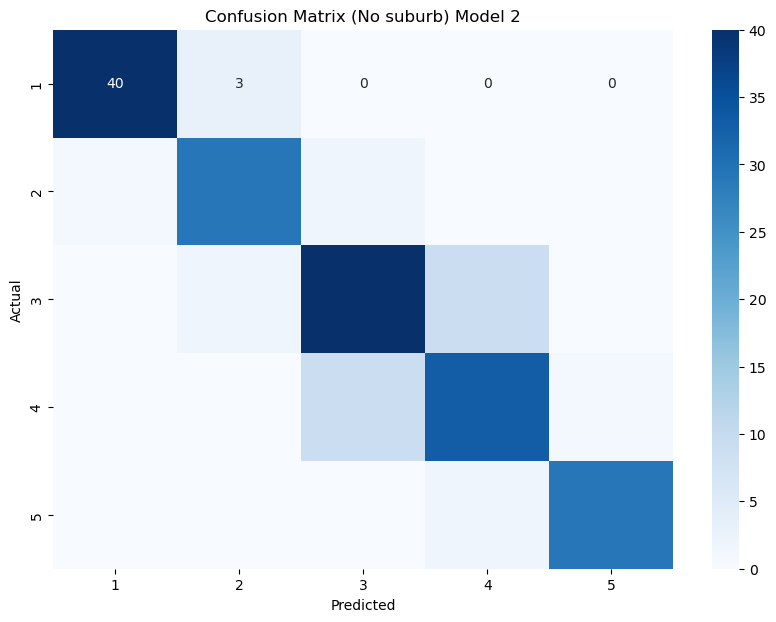

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.85      0.91      0.88        32
           2       0.78      0.78      0.78        51
           3       0.75      0.77      0.76        43
           4       0.97      0.94      0.95        31

    accuracy                           0.85       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.86      0.85      0.86       200



In [31]:
#confusion matrix for Model 2 
predicted_categories = np.argmax(predicted_probabilities, axis=1)
y_test_numerical = y_test.cat.codes
labels = np.arange(len(y.cat.categories)) 
conf_matrix = confusion_matrix(y_test_numerical, predicted_categories, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['score'].cat.categories, yticklabels=df['score'].cat.categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (No suburb) Model 2')
plt.show()

# Classification report
print(classification_report(y_test_numerical, predicted_categories, labels=labels))

In [32]:
# Model 3

In [33]:
#modelling without agency names 
df['score'] = df['score'].astype('category')
df['sentiment'] = df['sentiment'].astype('category')

categorical_columns = ['sentiment']
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)

numeric_columns = ['weekly_price', 'n_bedrooms']
combined_features_df = pd.concat([df[numeric_columns], df_encoded], axis=1)
X = combined_features_df.astype(int)
y = df['score']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

model = OrderedModel(y_train, X_train, distr='logit')
res_log = model.fit(method='bfgs', disp=False)

res_log.summary()

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/miscmodels/ordinal_model.py:206: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -139.33
Model:                   OrderedModel   AIC:                             292.7
Method:            Maximum Likelihood   BIC:                             323.4
Date:                Fri, 24 May 2024                                         
Time:                        07:38:32                                         
No. Observations:                 600                                         
Df Residuals:                     593                                         
Df Model:                           3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
weekly_price      0.3460      0.034     10.163      0.000       0.279       0.413
n_bedrooms       -0.3259      0.399     -0.817      0.414      -1.108       0.456
sentiment_1.0     0.1586      0.311      0.510      0.610      -0.451       0.769
1/2              65.7368      6.607      9.949      0.000      52.787      78.687
2/3               3.0051      0.103     29.127      0.000       2.803       3.207
3/4               2.7836      0.102     27.170      0.000       2.583       2.984
4/5               1.9055      0.097     19.662      0.000       1.716       2.095
=================================================================================
"""

In [34]:
predicted_probabilities_noagencynames = res_log.model.predict(res_log.params, exog=X_test)
predicted_probabilities_noagencynames

array([[1.96311537e-16, 1.14915463e-07, 5.49331586e-01, 4.49682287e-01,
        9.86011956e-04],
       [2.99673962e-31, 1.75421050e-22, 1.86071902e-15, 1.54479116e-12,
        1.00000000e+00],
       [3.18701195e-16, 1.86559043e-07, 6.64301153e-01, 3.35091073e-01,
        6.07587446e-04],
       [5.58084578e-20, 3.26687650e-11, 3.46402758e-04, 2.23276508e-01,
        7.76377089e-01],
       [3.56911011e-02, 9.64308853e-01, 4.61555011e-08, 4.44089210e-15,
        0.00000000e+00],
       [3.18701195e-16, 1.86559043e-07, 6.64301153e-01, 3.35091073e-01,
        6.07587446e-04],
       [9.99999853e-01, 1.46876423e-07, 2.22044605e-16, 0.00000000e+00,
        0.00000000e+00],
       [8.65314198e-15, 5.06529012e-06, 9.81722958e-01, 1.82495857e-02,
        2.23909687e-05],
       [1.02660671e-11, 5.97358048e-03, 9.94010732e-01, 1.56687538e-05,
        1.88734951e-08],
       [3.48023917e-17, 2.03723804e-08, 1.77694522e-01, 8.16768946e-01,
        5.53651128e-03],
       [2.52591506e-34, 1.4786

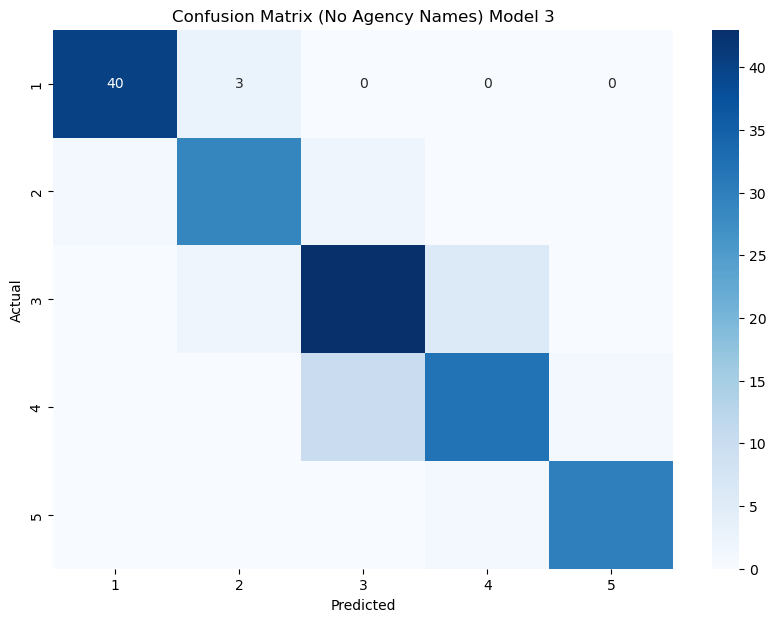

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.85      0.91      0.88        32
           2       0.78      0.84      0.81        51
           3       0.82      0.74      0.78        43
           4       0.97      0.97      0.97        31

    accuracy                           0.87       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.87      0.87      0.87       200



In [35]:
predicted_probabilities_noagencynames = res_log.model.predict(res_log.params, exog=X_test)
predicted_categories_noagency = np.argmax(predicted_probabilities_noagencynames, axis=1)
y_test_numerical = y_test.cat.codes
labels = np.arange(len(y.cat.categories)) 
conf_matrix = confusion_matrix(y_test_numerical, predicted_categories_noagency, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['score'].cat.categories, yticklabels=df['score'].cat.categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (No Agency Names) Model 3')
plt.show()

#Classification report
print(classification_report(y_test_numerical, predicted_categories_noagency, labels=labels))

In [36]:
# Model 4

In [37]:
#model 4 only with bedrooms and sentiment
df['score'] = df['score'].astype('category')
df['sentiment'] = df['sentiment'].astype('category')

categorical_columns = ['sentiment']
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)

numeric_columns = ['weekly_price']
combined_features_df = pd.concat([df[numeric_columns], df_encoded], axis=1)

X = combined_features_df.astype(int)
y = df['score']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

model = OrderedModel(y_train, X_train, distr='logit')
res_log = model.fit(method='bfgs', disp=False)

res_log.summary()

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/miscmodels/ordinal_model.py:206: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  score   Log-Likelihood:                -139.66
Model:                   OrderedModel   AIC:                             291.3
Method:            Maximum Likelihood   BIC:                             317.7
Date:                Fri, 24 May 2024                                         
Time:                        07:38:32                                         
No. Observations:                 600                                         
Df Residuals:                     594                                         
Df Model:                           2                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
weekly_price      0.3475      0.034     10.160      0.000       0.280       0.415
sentiment_1.0     0.1777      0.310      0.574      0.566      -0.429       0.785
1/2              66.3632      6.615     10.033      0.000      53.399      79.328
2/3               3.0252      0.099     30.480      0.000       2.831       3.220
3/4               2.7794      0.103     26.955      0.000       2.577       2.982
4/5               1.9047      0.097     19.624      0.000       1.714       2.095
=================================================================================
"""

In [38]:
predicted_probabilities_nobedrooms = res_log.model.predict(res_log.params, exog=X_test)
predicted_probabilities_nobedrooms

array([[1.67080772e-16, 1.47455527e-07, 5.93841808e-01, 4.05331556e-01,
        8.26488855e-04],
       [1.61506820e-31, 1.42536310e-22, 1.41331890e-15, 1.16719319e-12,
        1.00000000e+00],
       [1.99564969e-16, 1.76124137e-07, 6.35881435e-01, 3.63426339e-01,
        6.92050196e-04],
       [3.36597548e-20, 2.97060969e-11, 2.94464094e-04, 1.95556216e-01,
        8.04149320e-01],
       [3.50532736e-02, 9.64946695e-01, 3.11917724e-08, 3.10862447e-15,
        0.00000000e+00],
       [1.99564969e-16, 1.76124137e-07, 6.35881435e-01, 3.63426339e-01,
        6.92050196e-04],
       [9.99999862e-01, 1.37794949e-07, 2.22044605e-16, 0.00000000e+00,
        0.00000000e+00],
       [5.39654519e-15, 4.76264701e-06, 9.79258786e-01, 2.07108417e-02,
        2.56091771e-05],
       [6.72438147e-12, 5.89952802e-03, 9.94083478e-01, 1.69732641e-05,
        2.05527628e-08],
       [2.93989487e-17, 2.59457623e-08, 2.04622871e-01, 7.90698093e-01,
        4.67900948e-03],
       [1.29614724e-34, 1.1439

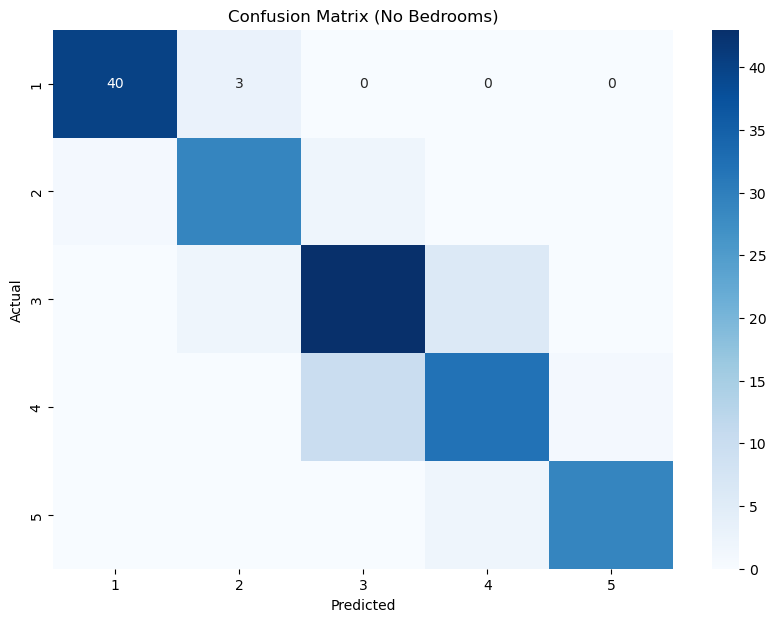

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.85      0.91      0.88        32
           2       0.78      0.84      0.81        51
           3       0.80      0.74      0.77        43
           4       0.97      0.94      0.95        31

    accuracy                           0.86       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.87      0.86      0.87       200



In [39]:
predicted_probabilities_nobedrooms = res_log.model.predict(res_log.params, exog=X_test)
predicted_categories_nobedrooms = np.argmax(predicted_probabilities_nobedrooms, axis=1)
y_test_numerical = y_test.cat.codes
labels = np.arange(len(y.cat.categories))  
conf_matrix = confusion_matrix(y_test_numerical, predicted_categories_nobedrooms, labels=labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['score'].cat.categories, yticklabels=df['score'].cat.categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (No Bedrooms)')
plt.show()
print(classification_report(y_test_numerical, predicted_categories_nobedrooms, labels=labels))